## This notebook demonstrates a few different methods for deriving photon-limited RV uncertainty from a CCF-derived RV of sample spectrum.

The goal is to check that all techniques converge to the same answers, and that all scaling factors are correct when computing the uncertainty from the CCF alone.

- This is tested by making a fake spectrum of (absorption) delta functions, each with different depths, and calculating the photon-limited uncertainty using standard techniques outlined in Bouchy et al. 2001 (B01)

- Noise is then added to the spectrum at known levels and the RV is estimated by fitting the computed CCF with a simple Gaussian. The scatter in the measured RVs (after many iterations of noise generation) is then compared to the B01 value computed from the underlying spectrum.

- Additionally, an independant estimate of the uncertainty is computed from the CCF, following the equations listed in Boisse et al. 2010 (B10). This method essentially treats the CCF as a single, high-SNR line and follows a similar prescription as B01 to calculate the RV uncertainty.


Start with defining the function that computes CCF-based error, as defined in Boisse et al. 2010:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PRVccf.libs import fit_gaussian_to_ccf 
from ccf_tools import spec_make, ccf_make, spec_rv_noise_calc
from ccf_fitting_tools import fit_gaussian_to_ccf_weighted
from scipy.optimize import curve_fit

def ccf_error_calc(vel_arr, ccf, mask_wid, center=0., fit_half_wid=10., pix_wid_vel=0.6):
    '''
    Estimates photon-limited velocity uncertainty of cross-correlation
    function using methods in Boisse et al. 2010 (B10), Appendix A.2.

    Calculates weighted slope information of CCF and converts to
    approximate RV uncertainty based on photon noise alone.

    Modified slightly by SPH to include scale factor to account
    for relative velocity step size of CCF compared to native NEID pixels.

    Parameters
    ----------
    vel_arr : :obj:'arr' of :obj:`float`
        CCF velocity step array [km/s]

    ccf : :obj:'arr' of :obj:`float`
        CCF array
    
    mask_wid : :obj: 'arr' of :obj:'float'
        width of mask in km/s

    fit_wid : :obj:`float`
        Width of CCF being fit for RVs [km/s]

    pix_wid_vel : :obj:`float`
        Velocity span per pixel [km/s/pixel]

    Returns
    -------
    sigma_ccf : :obj:`float`
        Estimated photon-limited uncertainty of RV measurement
        using specified ccf [km/s]

    S Halverson - JPL - 29-Sep-2019
    '''
    
    # get approximate CCF velocity step size
    ccf_vel_step = np.mean(np.diff(vel_arr)) # km/s
    
    # isolate only velocity steps in the CCF that are used for fitting
    inds_fit = np.where((vel_arr >= ((-1.) * fit_half_wid)) & (vel_arr <= fit_half_wid))
    vels_fit = vel_arr[inds_fit]
    ccf_fit = ccf[inds_fit]
    
    # scaling factor used to compensate for the difference between
    # width of CCF velocity step in units of native spectrum pixels
    # used to correct for CCF 'oversampling'
    n_scale_pix = (ccf_vel_step / pix_wid_vel) # number of NEID pixels per ccf step

    # noise of each CCF point (assumed to be photon noise only)
    noise_ccf = (ccf_fit) ** 0.5

    # calculate slopes
    deriv_ccf = np.gradient(ccf_fit, vels_fit)

    #weight them by the noise
    weighted_slopes = (deriv_ccf)**2. / (noise_ccf)**2.

    # numerator of equation A.2 in B10
    top = (np.nansum(weighted_slopes)) ** 0.5

    # demonimator of equation A.2 in B10
    bottom = (np.nansum(ccf_fit)) ** 0.5

    # calculate Q-factor of CCF
    qccf = (top / bottom) * (n_scale_pix ** (0.5))

    # calculate final ccf uncertainty
    sigma_ccf = 1. / (qccf * ((np.nansum(ccf_fit)) ** 0.5)) # km/s

    return sigma_ccf



gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


Next, we'll setup the fake spectrum which which to measure the RV of:

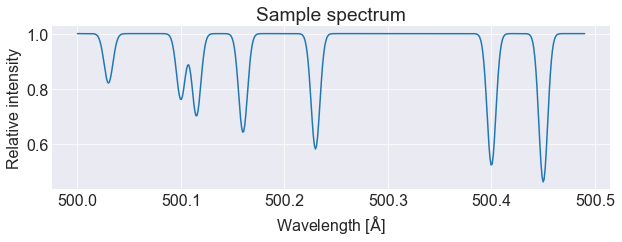

In [2]:
#---------------------------------------------------
# spectrum parameters (currently matched to NEID)
#----------------------------------
# spectrometer resolution
res = 100e3
# PSF sampling (FWHM) in pixels
psf_sampling = 5.
# fundamental constants
c = 299792.458 # km/s
# resolution element width in velocity
res_element_wid = c / res	# km/s
# pixel width in velocity
vel_pixel = res_element_wid / psf_sampling	# km/s / pixel
# test spectrum wavelength range
wvl_range = [500., 500.49]
#---------------------------------------------------

#---------------------------------------------------
# fake spectrum generation
#---------------------------------------------------
# width of resolution element in nm
width_res = np.mean(wvl_range) / res # nm/psf

# sampling resolution for wavelength array
band = np.amax(wvl_range) - np.amin(wvl_range)
sampling_res = (band / (width_res)) * psf_sampling #total number of pixels

# master wavelength array
wvl_arr = np.linspace(np.amin(wvl_range), np.amax(wvl_range), int(sampling_res))

# set wavelength spacing
nwvls = 9
line_wvls = np.linspace(np.amin(wvl_range),np.amax(wvl_range), nwvls) 
line_wvls = line_wvls[1:nwvls-1]

# uneven wavelength spacing
line_wvls = [500.03,500.1,500.115,500.16,500.23,500.4,500.45]

# set weights / depths
scales = np.zeros_like(wvl_arr) + 0.5
scales = np.linspace(0.3,0.9,len(line_wvls)) * 0.6

# fwhm of lines
fwhms = np.zeros_like(wvl_arr) + width_res*2.

# final noiseless spectrum
spec = spec_make(wvl_arr, scales, line_wvls, fwhms)
#---------------------------------------------------

#---------------------------------------------
# plot sample noiseless spectrum
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = [10, 3]
plt.rcParams.update({'font.size': 16})
plt.title('Sample spectrum')
plt.ylabel('Relative intensity')
plt.xlabel('Wavelength [$\mathrm{\AA}$]')
plt.plot(wvl_arr,spec)
#---------------------------------------------


Now set up the CCF loop parameters, including how wide the mask lines are and how many steps will be computed.

In [3]:
#---------------------------------------------------
# CCF loop parameters
#---------------------------------------------------
#base spectrum SNR array -- loop through these values for testing
snr_arr = np.arange(10,100,10)

#number of noise trails for each SNR value
ntrials = 50.

# CCF parameters
vmin = -20. # km/s
vmax = 20. # km/s
vstep = 0.3 # km/s

# CCF fitting window
fit_min = -10. # km/s
fit_max = 10. # km/s
center = 0. # km/s

# base velocity step array
velocity_loop = np.arange(vmin, vmax, vstep)
velsize = len(velocity_loop)
mask_wid = 0.4 # km/s

# ccf fitting half width
fit_half_wid = (fit_max - fit_min) / 2.
#---------------------------------------------------

Finally, compute the RV uncertainty of the spectrum as a function of SNR using the techniques described above. 

- Generate *ntrials* of noise for each SNR value, then compute the scatter in recovered RVs with both weighted and unweighted CCF fits.

- Compute the RV uncertainty from the CCF.

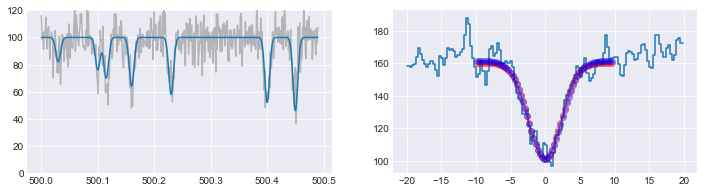

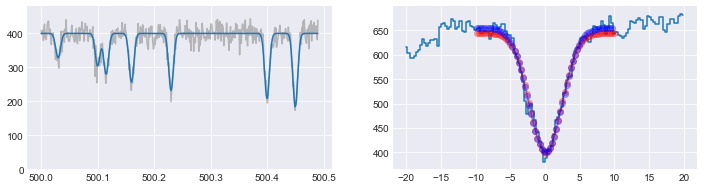

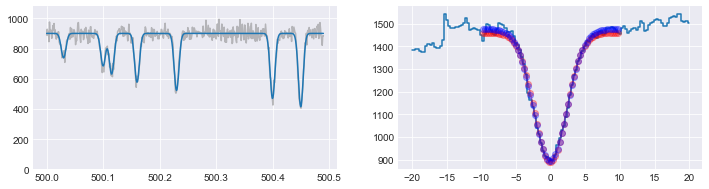

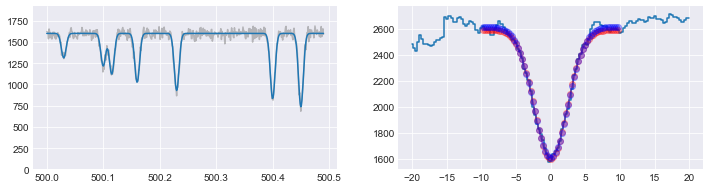

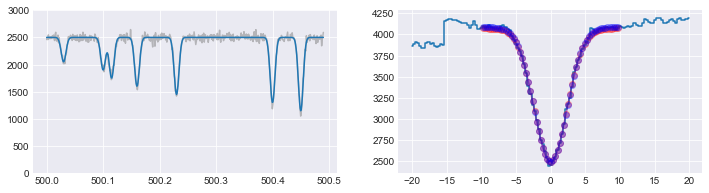

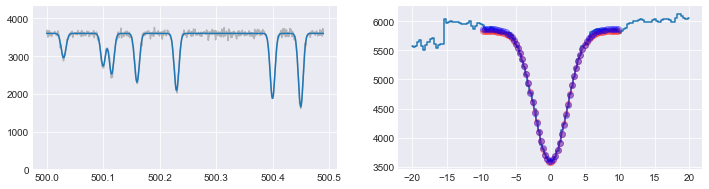

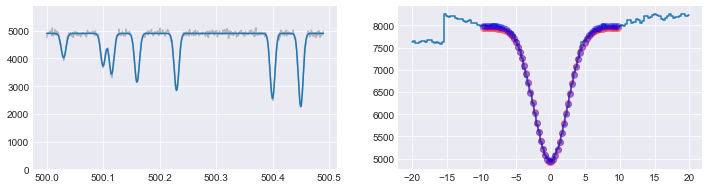

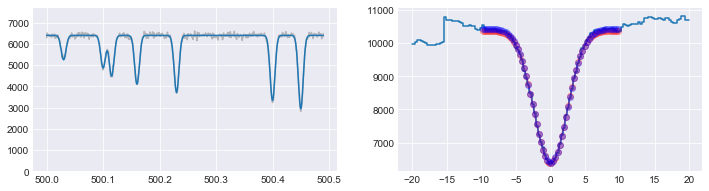

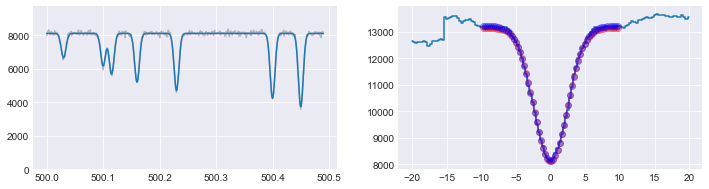

In [4]:
%matplotlib inline

#---------------------------------------------------
# initialize arrays
#---------------------------------------------------
sigma_rv_spec = []
sigma_rv_ccf = []
sigma_rv_meas = []
sigma_rv_meas_weighted = []
#---------------------------------------------------

# loop through snr values and calculate noise several ways
for snr in snr_arr:
    
    #scale spectrum to SNR
    spec_i =  spec * snr**2. # photons

    # calculate RV uncertainties from spectrum
    sigma_rv_i = spec_rv_noise_calc(wvl_arr, spec_i) # km/s
    sigma_rv_spec.append(sigma_rv_i)

    # initialize dummy ccf array
    sigma_ccf_t = []
    calc_rv = []
    calc_rv_weighted = []
    
    # loop through many trials of noise generation
    for t in range(int(ntrials)):

        # calculate noise and add to spectrum
        noise = np.random.standard_normal(wvl_arr.shape) * snr
        spec_noisy = spec_i + noise

        # calculate CCF
        ccf = ccf_make(wvl_arr, spec_noisy, line_wvls, mask_wid, scales, velocity_loop)
        
        #------------------------------
        # fit CCF with gaussian, unweighted
        gaussian_fit, g_x, g_y, rv = fit_gaussian_to_ccf(velocity_loop, ccf,
                                                         center, fit_half_wid)
    
        # fit CCF with gaussian, unweighted
        rv_weighted, fit_vels, ccf_fit_weighted = fit_gaussian_to_ccf_weighted(velocity_loop, ccf,
                                                                               center, fit_half_wid)

        # calculate error from the CCF itself
        ccf_error = ccf_error_calc(velocity_loop, ccf, mask_wid,
                                   center, fit_half_wid, vel_pixel) # km/s
        
        # calculate error from the gaussian fit to the CCF 
        # (smoother function, less suceptible to high frequency noise)
        ccf_error_from_fit = ccf_error_calc(fit_vels, ccf_fit_weighted, mask_wid,
                                   center, fit_half_wid, vel_pixel) # km/s
        
        #------------------------------
        
        # fill in master arrays with computed values
        calc_rv.append(rv)
        calc_rv_weighted.append(rv_weighted)
        sigma_ccf_t.append(ccf_error)
        
        # plot one iteration of spectrum and CCF
        if t == 0:
            plt.figure(figsize=(12, 3))
            plt.subplot(1, 2, 1)
 
            # plot spectrum
            plt.plot(wvl_arr,spec_noisy,'gray',alpha=0.5)
            plt.plot(wvl_arr,spec_i)
            plt.ylim(0,max(spec_i) * 1.2)
             
            # plot fits
            plt.subplot(1, 2, 2)
            plt.plot(velocity_loop, ccf, drawstyle='steps-mid')
            plt.plot(g_x, gaussian_fit(g_x) + np.median(ccf), '-ro', alpha=0.3)
            plt.plot(fit_vels, ccf_fit_weighted, '-bo', alpha=0.3)
            #plt.plot(g_x, g_y + np.median(ccf), '-co', alpha=0.3)
            plt.show()

    # append arrays accordingly
    sigma_rv_ccf.append(np.mean(sigma_ccf_t)) # take the mean of the CCF-derived noise values (should all be roughly the same)
    sigma_rv_meas.append(np.std(calc_rv)) # stddev of calculated rvs from unweighted fit
    sigma_rv_meas_weighted.append(np.std(calc_rv_weighted)) # stddev of calculated rvs from weighted fit



Plot comparison between different noise estimates, compared to 'ground truth' from spectrum (blue line in above plots, grey line in noise plot below)

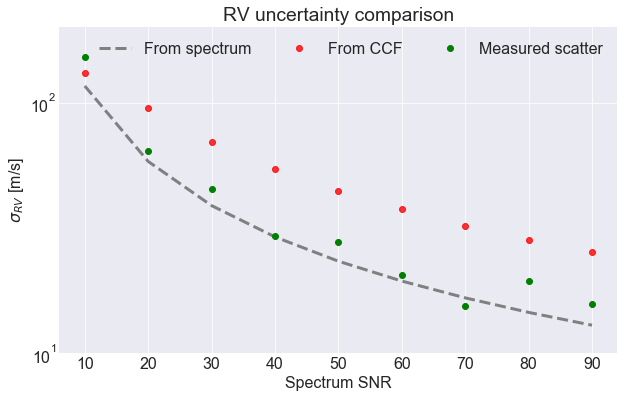

In [5]:
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams.update({'font.size': 16})
plt.title('RV uncertainty comparison')
plt.ylabel('$\sigma_{RV}$ [m/s]')
plt.xlabel('Spectrum SNR')

plt.plot(snr_arr,np.array(sigma_rv_spec) * 1e3,'gray',linestyle='--',linewidth=3,label='From spectrum') # 'ground truth' from spectrum
plt.plot(snr_arr,np.array(sigma_rv_ccf) * 1e3,'ro',alpha=0.8, label='From CCF') # measured from CCF
# plt.plot(snr_arr,np.array(sigma_rv_meas_weighted) * 1e3,'bo',alpha=0.5) # scatter in measured RVs from CCF, weighted
plt.plot(snr_arr,np.array(sigma_rv_meas) * 1e3,'go', label='Measured scatter') # scatter in measured RVs from CCF
plt.yscale('log',basey=10)
plt.ylim(10,200)


plt.legend(loc="best", ncol=3)